In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pima = pd.read_csv('diabetes.csv', sep=';')
df = pd.read_csv('diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('diabetes_pt2.csv', sep=';')

In [3]:
feature_columns = ['Glucose', 'Age', 'BMI', 'DiabetesPedigreeFunction', 'BloodPressure']

stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}

test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [4]:
sm2 = CmdStanModel(stan_file='code_2.stan')

fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=1000, seed=2108005)
# print(fit2.summary())
df3 = fit2.draws_pd()
df3.head()

INFO:cmdstanpy:compiling stan file /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/code_3.stan to exe file /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/code_3
INFO:cmdstanpy:compiled model executable: /GA/Data-Analytics/Project/PimaDiabetesPrediction/LogisticRegresion/code_3
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▋         | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)

chain 1 |▉         | 00:00 Iteration:  100 / 3000 [  3%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  200 / 3000 [  6%]  (Warmup)
chain 1 |█▌        | 00:00 Iteration:  300 / 3000 [ 10%]  (Warmup)


chain 1 |█▉        | 00:01 Iteration:  400 / 3000 [ 13%]  (Warmup)
chain 1 |██▏       | 00:01 Iteration:  500 / 3000 [ 16%]  (Warmup)

chain 1 |██▌       | 00:01 Iteration:  600 / 3000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  800 / 3000 [ 26%]  (Warmup)
chain 1 |███▍      | 00:01 Iteration:  900 / 3000 [ 30


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_glucose,beta_age,beta_bmi,beta_dpf,beta_bp
0,-174.756,0.999438,0.08905,6.0,63.0,0.0,177.624,-4.44327,0.024341,0.012087,0.019254,0.103939,-0.005157
1,-175.852,0.983285,0.08905,5.0,31.0,0.0,177.308,-4.95697,0.021222,0.025603,0.016335,0.052539,0.003112
2,-176.131,0.999885,0.08905,5.0,63.0,0.0,178.466,-4.03887,0.026228,0.050482,0.037853,0.209385,-0.040965
3,-177.810,0.948947,0.08905,6.0,63.0,0.0,180.574,-3.98511,0.016955,0.059240,0.036584,0.237848,-0.025630
4,-172.804,0.964018,0.08905,5.0,31.0,0.0,179.118,-5.11528,0.024694,0.044134,0.036969,0.111485,-0.017377


In [5]:
alpha_mean = df3['alpha'].mean()
beta_glucose_mean = df3['beta_glucose'].mean()
beta_age_mean = df3['beta_age'].mean()
beta_bmi_mean = df3['beta_bmi'].mean()
beta_dpf_mean = df3['beta_dpf'].mean()
beta_bp_mean = df3['beta_bp'].mean()

In [6]:
logit_preds_test = alpha_mean + (test2_data['X'][:, 0] * beta_glucose_mean +
                                 test2_data['X'][:, 1] * beta_age_mean +
                                 test2_data['X'][:, 2] * beta_bmi_mean +
                                 test2_data['X'][:, 3] * beta_dpf_mean +
                                 test2_data['X'][:, 4] * beta_bp_mean)

probs_test2 = 1 / (1 + np.exp(-logit_preds_test))

probs_df = pd.DataFrame(probs_test2, columns=['Probability'])
print(probs_df.head())

   Probability
0     0.188607
1     0.328434
2     0.537695
3     0.369735
4     0.237546


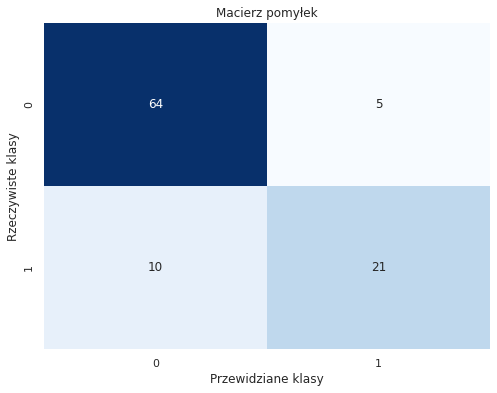

In [7]:

preds_test2 = (probs_test2 > 0.5).astype(int)

conf_matrix = confusion_matrix(test2_data['y'], preds_test2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziane klasy')
plt.ylabel('Rzeczywiste klasy')
plt.show()